In [786]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import sympy as sp
from utils.fehler_gauss import fehler_gauss, weighted_mean
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Allgemeine Daten

In [787]:
lambda_laser = 532e-9
T = 19 + 274.2
luftfeuchtigkeit = 0.48
dicke_glasplatte = 4.92e-3
u_dicke_glasplatte = 0.01e-3

## Ganghöhe Spiegel

In [788]:
# Anzahl Maxima
N = 100
u_N = 5

# Wegdifferenz berechnen
l_symbol, n_symbol, N_symbol, lambda_symbol = sp.symbols("l n N lambda")
delta_s = 2 * l_symbol * n_symbol
delta_s

2*l*n

In [789]:
# Maximumsbedingung
maximumsbedingung = sp.Eq(N_symbol * lambda_symbol, delta_s)
maximumsbedingung

Eq(N*lambda, 2*l*n)

In [790]:
# Wegdifferenz
l_formula = sp.solve(maximumsbedingung, l_symbol)[0]
l_formula

N*lambda/(2*n)

In [791]:
l_val, u_l_val = fehler_gauss(
    l_formula,
    [N_symbol, lambda_symbol, n_symbol],
    [N, lambda_laser, 1],
    [u_N, 0, 0]
)
print(f"l = {l_val * 1e6} +- {u_l_val * 1e6}", "µm")

l = 26.6 +- 1.3300000000000003 µm


In [792]:
# Ganghoehe bestimmen (Verschiebung bei unseren Umdrehungen auf eine volle Umdrehung hochrechnen)
skalenstriche_schraube = pd.read_excel("INT.xlsx", sheet_name="GanghoeheSpiegel")["Mikrometerschraube"].values
u_skalenstriche_schraube = 0.5

umdrehungen = skalenstriche_schraube / 50 # Eine Umdrehung entspricht 50 Skalenstrichen
u_umdrehungen = u_skalenstriche_schraube / 50

umdrehungen, u_umdrehungen

(array([0.63, 0.62, 0.6 , 0.64]), 0.01)

In [793]:
k_symbol = sp.symbols("k") # k ist die Anzahl der Umdrehungen

ganghoehe_formula = l_symbol / k_symbol
ganghoehe_formula

l/k

In [794]:
ganghoehen_val, u_ganghoehen_val = fehler_gauss(
    ganghoehe_formula,
    [l_symbol, k_symbol],
    [l_val, umdrehungen],
    [u_l_val, u_umdrehungen]
)

ganghoehe_val, u_ganghoehe_val = weighted_mean(ganghoehen_val, u_ganghoehen_val)
print(f"Ganghoehe = {ganghoehe_val * 1e6} +- {u_ganghoehe_val * 1e6}", "µm")

Ganghoehe = 42.7022907196989 +- 1.1216976993701355 µm


## Plexiglasscheibe

- $x$ Strecke, um die die Schraube reingedreht ist
- $d$ Hebelarm zwischen Ansatzpunkt Schraube und Drehpunkt Glasscheibe

$\tan\alpha = \frac{x}{d} \implies \alpha = \arctan \frac{x}{d}$

In [795]:
x_symbol, h_symbol, alpha_symbol, d_symbol = sp.symbols("x h alpha d")

hebelarm = 28e-3  # Hebelarm zwischen Ansatzpunkt Schraube und Drehpunkt der Glasscheibe
u_hebelarm = 1e-3  # Unsicherheit für Hebelarm zum Spaß
u_mikrometerschraube = 0.01e-3  # Ableseungenauigkeit

# Daten einlesen
df = pd.read_excel("INT.xlsx", sheet_name="Plexiglas")
df[["MikrometerschraubeA", "MikrometerschraubeB"]] = (
    df[["MikrometerschraubeA", "MikrometerschraubeB"]] * 1e-3
    - 0.00280  # in den Nullpunkt verschieben
)

# Winkel aus Mikrometerschraubeneinstellung bestimmen
alpha_formula = sp.atan(x_symbol / d_symbol)
for richtung in ["A", "B"]:
    alpha_vals, u_alpha_vals = fehler_gauss(
        alpha_formula,
        [x_symbol, d_symbol],
        [df[f"Mikrometerschraube{richtung}"], hebelarm],
        [u_mikrometerschraube, u_hebelarm],
    )
    df[f"alpha{richtung}"] = alpha_vals
    df[f"u_alpha{richtung}"] = u_alpha_vals

# Beide Richtungen zusammenfassen
df = pd.DataFrame(
    {
        "alpha": np.concatenate([df["alphaA"], df["alphaB"]]),
        "u_alpha": np.concatenate([df["u_alphaA"], df["u_alphaB"]]),
        "Maxima": np.concatenate([df["Maxima"], df["Maxima"]]),
    }
).dropna().iloc[1:]
df

,alpha,u_alpha,Maxima
1,0.028921,0.001092,3
2,0.041761,0.001532,6
3,0.050315,0.001829,9
4,0.060640,0.002190,12
5,0.068820,0.002476,15
6,0.076280,0.002737,18
7,0.081604,0.002923,21
8,0.086214,0.003084,24
9,0.000000,0.000357,0
10,-0.036769,0.001360,3


In [796]:
# Optischer Wegunterschied mit der Anzahl Maxima berechnen
delta_s_formula = N_symbol * lambda_symbol
delta_s_formula

N*lambda

In [797]:
delta_s_vals, u_delta_s_vals = fehler_gauss(
    delta_s_formula,
    [N_symbol, lambda_symbol],
    [df["Maxima"], lambda_laser],
    [2, 0] # 2 Maxima Unsicherheit dieses Mal
)
df["delta_s"] = delta_s_vals
df["u_delta_s"] = u_delta_s_vals
df[["delta_s", "u_delta_s"]] * 1e6 # Wegdifferenzen in µm anzeigen

,delta_s,u_delta_s
1,1.596,1.064
2,3.192,1.064
3,4.788,1.064
4,6.384,1.064
5,7.980,1.064
6,9.576,1.064
7,11.172,1.064
8,12.768,1.064
9,0.000,1.064
10,1.596,1.064


n = 1.4478431998579908 +- 0.005790583969553881
alpha0 = -0.00420070844635896 +- 0.0003249156385727962


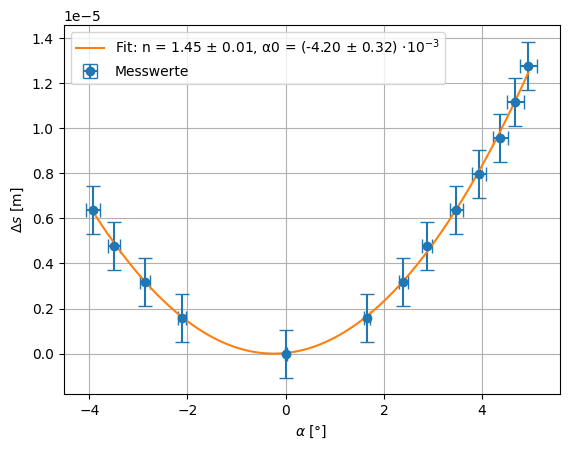

In [798]:
# Brechungsindex über Fit bestimmen
def delta_s_func(alpha, n, alpha0):
    alpha_shifted = alpha - alpha0
    return (
        2
        * dicke_glasplatte
        * (1 - n - np.cos(alpha_shifted) + np.sqrt(n**2 - np.sin(alpha_shifted) ** 2))
    )
popt, pcov = curve_fit(
    delta_s_func,
    df["alpha"],
    df["delta_s"],
    sigma=df["u_delta_s"],
    p0=[1.4, 0],
)
print(f"n = {popt[0]} +- {np.sqrt(pcov[0, 0])}")
print(f"alpha0 = {popt[1]} +- {np.sqrt(pcov[1, 1])}")

X = np.linspace(df["alpha"].min(), df["alpha"].max(), 1000)
Y = delta_s_func(X, *popt)

# Messdaten plotten
plt.errorbar(
    np.rad2deg(df["alpha"]),
    df["delta_s"],
    xerr=np.rad2deg(df["u_alpha"]),
    yerr=df["u_delta_s"],
    fmt="o",
    capsize=5,
    label="Messwerte"
)
# Fit plotten
plt.plot(np.rad2deg(X), Y, label=f"Fit: n = {popt[0]:.2f} ± {np.sqrt(pcov[0, 0]):.2f}, α0 = ({popt[1]*1e3:.2f} ± {np.sqrt(pcov[1, 1])*1e3:.2f}" + r") $\cdot 10^{-3}$")
plt.xlabel(r"$\alpha$ [°]")
plt.ylabel(r"$\Delta s$ [m]")
plt.grid(True)
plt.legend()

## Druckabhängiger Brechungsindex

,Druck,Maxima
0,0.00,0
1,0.05,3
2,0.10,6
3,0.16,9
4,0.22,12
5,0.28,15
6,0.34,18
7,0.40,21
8,0.46,24
9,0.52,27


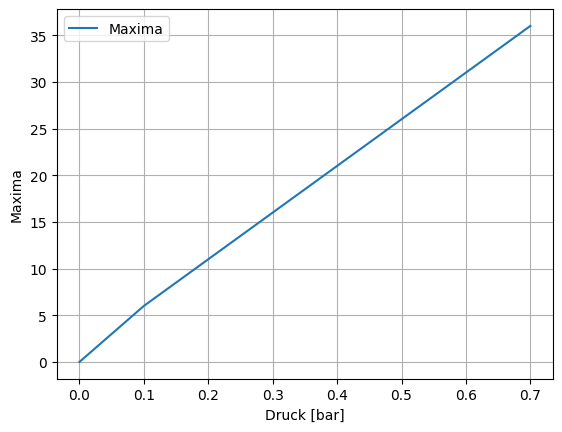

In [799]:
df = pd.read_excel("INT.xlsx", sheet_name="Druck")

df.plot(x="Druck", y="Maxima")
plt.grid(True)
plt.xlabel("Druck [bar]")
plt.ylabel("Maxima")
df